<a href="https://colab.research.google.com/github/Pmilivojevic/PyTorch/blob/main/VAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.modules.activation import ReLU
import matplotlib.pyplot as plt
from torch.nn.modules.pooling import AdaptiveAvgPool2d
from torch.ao.nn.quantized.modules.conv import ConvTranspose2d

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
transform = transforms.ToTensor()
cifar10_dataset = datasets.CIFAR10(
    root='/content/drive/MyDrive/Colab Notebooks/Dataset',
    train=True,
    download=True,
    transform=transform
)
data_loader = torch.utils.data.DataLoader(
    dataset=cifar10_dataset,
    batch_size=64,
    shuffle=True
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12633506.84it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/Dataset/cifar-10-python.tar.gz to /content/drive/MyDrive/Colab Notebooks/Dataset


In [ ]:
latent_dim = 64
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [ ]:
class VAutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 4),
        nn.AdaptiveAvgPool2d(1)
    )

    self.fc1 = nn.Linear(128, 256)
    self.fc_mu = nn.Linear(256, latent_dim)
    self.fc_log_var = nn.Linear(256, latent_dim)
    self.fc2 = nn.Linear(latent_dim, 128)

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, 3, 2, 1, 1),
        nn.Sigmoid()
    )

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    sample = mu + (eps*std)

    return sample

  def forward(self, x):
    x = self.encoder(x)
    x = x.reshape(x.shape[0], -1)
    # print(x.shape)

    hidden = self.fc1(x)
    mu = self.fc_mu(hidden)
    log_var = self.fc_log_var(hidden)

    z = self.reparameterize(mu, log_var)
    z = self.fc2(z)
    z = z.view(-1, 128, 1, 1)

    x = self.decoder(z)

    return x, mu, log_var

In [ ]:
model = VAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 180
outputs = []

for epoch in range(num_epochs):
  for batch_ind, (image,_) in enumerate(data_loader):
    # image = image.to(device).reshape(image.shape[0], -1)
    image = image.to(device)

    recon, mu, log_var = model(image)
    recon_loss = criterion(recon, image)
    kl_loss = torch.mean(0.5*torch.sum(torch.exp(log_var) + mu**2 - 1 - log_var, dim=-1))
    loss = recon_loss + 0.00001*kl_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
  outputs.append((epoch, image, recon))

Epoch: 1, Loss: 0.0226
Epoch: 2, Loss: 0.0206
Epoch: 3, Loss: 0.0206
Epoch: 4, Loss: 0.0193
Epoch: 5, Loss: 0.0175
Epoch: 6, Loss: 0.0178
Epoch: 7, Loss: 0.0159
Epoch: 8, Loss: 0.0187
Epoch: 9, Loss: 0.0176
Epoch: 10, Loss: 0.0200
Epoch: 11, Loss: 0.0187
Epoch: 12, Loss: 0.0200
Epoch: 13, Loss: 0.0166
Epoch: 14, Loss: 0.0177
Epoch: 15, Loss: 0.0199
Epoch: 16, Loss: 0.0202
Epoch: 17, Loss: 0.0155
Epoch: 18, Loss: 0.0183
Epoch: 19, Loss: 0.0152
Epoch: 20, Loss: 0.0196
Epoch: 21, Loss: 0.0146
Epoch: 22, Loss: 0.0257
Epoch: 23, Loss: 0.0210
Epoch: 24, Loss: 0.0187
Epoch: 25, Loss: 0.0178
Epoch: 26, Loss: 0.0211
Epoch: 27, Loss: 0.0174
Epoch: 28, Loss: 0.0212
Epoch: 29, Loss: 0.0204
Epoch: 30, Loss: 0.0250
Epoch: 31, Loss: 0.0194
Epoch: 32, Loss: 0.0167
Epoch: 33, Loss: 0.0175
Epoch: 34, Loss: 0.0192
Epoch: 35, Loss: 0.0216
Epoch: 36, Loss: 0.0163
Epoch: 37, Loss: 0.0189
Epoch: 38, Loss: 0.0206
Epoch: 39, Loss: 0.0185
Epoch: 40, Loss: 0.0135
Epoch: 41, Loss: 0.0228
Epoch: 42, Loss: 0.0202
E

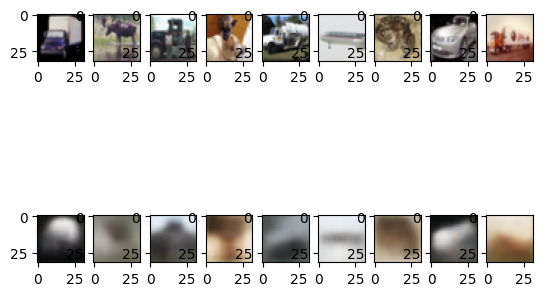

In [ ]:
for k in range(0, num_epochs, 6):
  # plt.figure(figsize=(9,2))

  imgs = outputs[k][1].cpu().detach().numpy()
  recons = outputs[k][2].cpu().detach().numpy()

  for i, img in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1)
    img = img.reshape(-1, 32, 32).transpose(1, 2, 0)
    plt.imshow(img)

  for i, rec in enumerate(recons):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1)
    rec = rec.reshape(-1, 32, 32).transpose(1, 2, 0)
    plt.imshow(rec)